In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
#import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.metrics import f1_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
#import os            ##  This module is for "operating system" interfaces
#import sys           ##  This module is for functionality relevant to the python run time
#path_to_datafolder = 'C:/Users/mjdom/source/repos/mdst_nlp_2021/data'
#print(os.listdir(path_to_datafolder))

In [ ]:
#df = pd.read_csv(path_to_datafolder+'/train.csv')
df = pd.read_csv('train.csv')
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [ ]:
X = df["text"].copy()
#X = df["text"]

authors = df["author"].copy()

# Label data
y = []
for author in authors:
    if author == "EAP":
        y.append([1, 0, 0])
    if author == "HPL":
        y.append([0, 1, 0])
    if author == "MWS":
        y.append([0, 0, 1])

y = np.array(y)

y_one_vector = []
for author in authors:
    if author == "EAP":
        y_one_vector.append(0)
    if author == "HPL":
        y_one_vector.append(1)
    if author == "MWS":
        y_one_vector.append(2)

y_one_vector = np.array(y_one_vector)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
encoder = tf.keras.layers.TextVectorization()
encoder.adapt(X)


In [ ]:
tf.__version__
vocab = encoder.get_vocabulary()

### CNN Model

In [ ]:
class CNN1d(tf.keras.Model):
    def __init__(self, conv1_filters, conv1_size, conv2_filters, conv2_size, dense1, encoder):
        super(CNN1d, self).__init__()

        self.encoder = encoder

        vocab = encoder.get_vocabulary()
        
        self.embedding = tf.keras.layers.Embedding(input_dim=len(vocab),output_dim=64,mask_zero=True)
        

        self.conv1 = tf.keras.layers.Conv1D(filters=conv1_filters,
                            kernel_size=conv1_size,
                            padding="same",
                            activation="relu",
                            data_format="channels_last",
                            )
        self.conv2 = tf.keras.layers.Conv1D(filters=conv2_filters,
                            kernel_size=conv2_size,
                            padding="same",
                            activation="relu",
                            data_format="channels_last",
                            )
        self.global_pool = tf.keras.layers.GlobalMaxPool1D()
        self.dense1 = tf.keras.layers.Dense(dense1, activation='relu')
        self.dense2 = tf.keras.layers.Dense(3, activation="softmax")

    def call(self, x, training=False):
        emb = self.encoder(x)
        emb = self.embedding(emb)
        conv1 = self.conv1(emb)
        conv2 = self.conv2(emb)
        z = tf.concat([conv1, conv2], axis=2)
        z = self.global_pool(z)
        z = self.dense1(z)
        z = self.dense2(z)
        return z

In [ ]:
def create_model(conv1_filters, conv1_size, conv2_filters, conv2_size, dense1):
    model = CNN1d(conv1_filters, conv1_size, conv2_filters, conv2_size, dense1, encoder)
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy']
    )
    return model

In [ ]:
callbacks = [
          tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
          tf.keras.callbacks.ModelCheckpoint(
            filepath="CNN_weights",
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)
]
with tf.device('/device:GPU:0'):
    cnn = create_model(128, 6, 128, 5, 128)
    history = cnn.fit(X_train, y_train, epochs=1,
                      validation_data=(X_test, y_test),
                      validation_steps=30,
                      callbacks=callbacks)

490/490 [==============================] - 30s 60ms/step - loss: 0.7005 - accuracy: 0.6796 - val_loss: 0.4982 - val_accuracy: 0.8029


In [ ]:
with tf.device('/device:GPU:0'):
    cnn.evaluate(X_test, y_test)

123/123 [==============================] - 1s 11ms/step - loss: 0.4983 - accuracy: 0.8026


### N-gram model

In [ ]:
max_features = 1000000
Vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=max_features, output_mode='tf-idf', ngrams=2)
with tf.device('/device:CPU:0'):
    Vectorizer.adapt(X)
vocab = Vectorizer.get_vocabulary()

In [ ]:
model_ngram = tf.keras.Sequential()
model_ngram.add(Vectorizer)
   
model_ngram.add(tf.keras.layers.Dense(25, activation='relu'))
model_ngram.add(tf.keras.layers.Dropout(0.2))
   
model_ngram.add(tf.keras.layers.Dense(3, activation='softmax'))
   
model_ngram.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(1e-3),
             metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):

    model_ngram.fit(X_train, y_train, epochs=1, batch_size=64,
             validation_data=(X_test,y_test),
             validation_steps=10)

pred = model_ngram.predict(df['text'])

245/245 [==============================] - 27s 109ms/step - loss: 0.5574 - accuracy: 0.7750 - val_loss: 0.3883 - val_accuracy: 0.8453


### LSTM model

In [ ]:
LSTM = tf.keras.Sequential()
LSTM.add(encoder)
LSTM.add(tf.keras.layers.Embedding(input_dim=len(vocab),output_dim=64,mask_zero=True))

LSTM.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,dropout=0.2,return_sequences=True)))

LSTM.add(tf.keras.layers.GlobalMaxPool1D())

LSTM.add(tf.keras.layers.Dropout(0.2))
   
LSTM.add(tf.keras.layers.Dense(3, activation='softmax'))
   
LSTM.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(1e-3),
             metrics=['accuracy'])


In [ ]:
with tf.device('/device:GPU:0'):

    LSTM.fit(X_train, y_train, epochs=2, batch_size=64,
             validation_data=(X_test,y_test),
             validation_steps=10)

Epoch 1/2
245/245 [==============================] - 96s 356ms/step - loss: 0.8032 - accuracy: 0.6286 - val_loss: 0.4895 - val_accuracy: 0.8266
Epoch 2/2
245/245 [==============================] - 83s 340ms/step - loss: 0.3141 - accuracy: 0.8874 - val_loss: 0.4426 - val_accuracy: 0.8375


In [ ]:
LSTM.evaluate(X_test, y_test)

123/123 [==============================] - 3s 28ms/step - loss: 0.4545 - accuracy: 0.8230


[0.4545390009880066, 0.8230336904525757]

### Collect predictions

In [ ]:
cnn_pred = cnn.predict(df['text'])
ngram_pred = model_ngram.predict(df['text'])
LSTM_pred = LSTM.predict(df['text'])

In [ ]:
ensemble_df = pd.DataFrame({
    "id": df["id"],
    "EAP_ngram": ngram_pred[:, 0],
    "HPL_ngram": ngram_pred[:, 1],
    "MWS_ngram": ngram_pred[:, 2],
    "EAP_cnn": cnn_pred[:, 0],
    "HPL_cnn": cnn_pred[:, 1],
    "MWS_cnn": cnn_pred[:, 2],
    "EAP_lstm": LSTM_pred[:, 0],
    "HPL_lstm": LSTM_pred[:, 1],
    "MWS_lstm": LSTM_pred[:, 2],

    "actual_author": df['author']
})
ensemble_df

,id,EAP_ngram,HPL_ngram,MWS_ngram,EAP_cnn,HPL_cnn,MWS_cnn,EAP_lstm,HPL_lstm,MWS_lstm,actual_author
0,id26305,0.997226,0.000522,0.002251,0.910401,0.066274,0.023325,0.996374,0.003226,0.000400,EAP
1,id17569,0.031950,0.939530,0.028520,0.071288,0.901178,0.027535,0.090181,0.895979,0.013840,HPL
2,id11008,0.996263,0.000110,0.003627,0.502240,0.486739,0.011020,0.989578,0.009477,0.000944,EAP
3,id27763,0.000347,0.000016,0.999637,0.014717,0.009851,0.975432,0.004662,0.001458,0.993881,MWS
4,id12958,0.039937,0.956385,0.003678,0.082752,0.906579,0.010670,0.097371,0.891301,0.011328,HPL
...,...,...,...,...,...,...,...,...,...,...,...
19574,id17718,0.952896,0.040134,0.006970,0.620086,0.205356,0.174557,0.614254,0.261061,0.124685,EAP
19575,id08973,0.848186,0.013869,0.137945,0.641661,0.006706,0.351634,0.824758,0.050509,0.124733,EAP
19576,id05267,0.999543,0.000097,0.000360,0.991442,0.005039,0.003519,0.994882,0.003444,0.001674,EAP
19577,id17513,0.108897,0.847488,0.043615,0.674165,0.158191,0.167643,0.603570,0.282073,0.114357,EAP


In [ ]:
X_final = ensemble_df[['EAP_ngram', 'HPL_ngram', 'MWS_ngram', \
                       'EAP_cnn', 'HPL_cnn','MWS_cnn', \
                       'EAP_lstm', 'HPL_lstm', 'MWS_lstm']].copy()
#, 'EAP_cnn', 'HPL_cnn', 'MWS_cnn'
authors_final = ensemble_df["actual_author"].copy()

# Label data
y_final = []
for author in authors_final:
    if author == "EAP":
        y_final.append([1, 0, 0])
    if author == "HPL":
        y_final.append([0, 1, 0])
    if author == "MWS":
        y_final.append([0, 0, 1])

y_final = np.array(y_final)
X_final

,EAP_ngram,HPL_ngram,MWS_ngram,EAP_cnn,HPL_cnn,MWS_cnn,EAP_lstm,HPL_lstm,MWS_lstm
0,0.997226,0.000522,0.002251,0.910401,0.066274,0.023325,0.996374,0.003226,0.000400
1,0.031950,0.939530,0.028520,0.071288,0.901178,0.027535,0.090181,0.895979,0.013840
2,0.996263,0.000110,0.003627,0.502240,0.486739,0.011020,0.989578,0.009477,0.000944
3,0.000347,0.000016,0.999637,0.014717,0.009851,0.975432,0.004662,0.001458,0.993881
4,0.039937,0.956385,0.003678,0.082752,0.906579,0.010670,0.097371,0.891301,0.011328
...,...,...,...,...,...,...,...,...,...
19574,0.952896,0.040134,0.006970,0.620086,0.205356,0.174557,0.614254,0.261061,0.124685
19575,0.848186,0.013869,0.137945,0.641661,0.006706,0.351634,0.824758,0.050509,0.124733
19576,0.999543,0.000097,0.000360,0.991442,0.005039,0.003519,0.994882,0.003444,0.001674
19577,0.108897,0.847488,0.043615,0.674165,0.158191,0.167643,0.603570,0.282073,0.114357


In [ ]:
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, test_size=0.2, random_state=42)


### Ensemble (mlp)

In [ ]:
ensemble = tf.keras.Sequential()
# for 3 model
ensemble.add(tf.keras.layers.Dense(36, activation='relu'))
ensemble.add(tf.keras.layers.Dropout(0.2))

ensemble.add(tf.keras.layers.Dense(3, activation='softmax'))

ensemble.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(1e-3),
             metrics=['accuracy'])


pass_same = tf.keras.Sequential()
pass_same.add(tf.keras.layers.InputLayer())
pass_same.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(1e-3),
             metrics=['accuracy'])

In [ ]:
ensemble.fit(X_train_final, y_train_final, epochs=2, batch_size=128,
         validation_data=(X_test_final,y_test_final),
         validation_steps=10)

Epoch 1/2
123/123 [==============================] - 1s 3ms/step - loss: 0.6201 - accuracy: 0.8472 - val_loss: 0.4581 - val_accuracy: 0.8555
Epoch 2/2
123/123 [==============================] - 0s 2ms/step - loss: 0.1512 - accuracy: 0.9801 - val_loss: 0.3838 - val_accuracy: 0.8602


In [ ]:
ensemble.evaluate(X_test_final,y_test_final)
model_ngram.evaluate(X_test,y_test)

123/123 [==============================] - 3s 24ms/step - loss: 0.3966 - accuracy: 0.8422


[0.3965936601161957, 0.842185914516449]

In [ ]:
ngram_results = model_ngram.evaluate(X_test,y_test)
LSTM_results =LSTM.evaluate(X_test,y_test)
cnn_results =cnn.evaluate(X_test,y_test)

ensemble_results =ensemble.evaluate(X_test_final,y_test_final)

df_results = pd.DataFrame({"ngram":ngram_results,"cnn":cnn_results,\
                           "LSTM":LSTM_results,"ensemble":ensemble_results})

123/123 [==============================] - 0s 1ms/step - loss: 0.3884 - accuracy: 0.8567


In [ ]:
df_results

,ngram,cnn,LSTM,ensemble
0,0.396594,0.498271,0.454539,0.388360
1,0.842186,0.802605,0.823034,0.856742


### Average of level one classifiers

In [ ]:
all_ave = (cnn_pred+ngram_pred +LSTM_pred )/3
X_train_ave, X_test_ave, y_train_ave, y_test_ave = train_test_split(all_ave, y_final, test_size=0.2, random_state=42)



pass_same.evaluate(X_test_ave,y_test_final)

123/123 [==============================] - 0s 1ms/step - loss: 0.3889 - accuracy: 0.8550


[0.38885003328323364, 0.8549540638923645]

In [ ]:
df_results['raw_ave'] = pass_same.evaluate(X_test_ave,y_test_final)
df_results

123/123 [==============================] - 0s 1ms/step - loss: 0.3889 - accuracy: 0.8550


,ngram,cnn,LSTM,ensemble,raw_ave
0,0.396594,0.498271,0.454539,0.388360,0.388850
1,0.842186,0.802605,0.823034,0.856742,0.854954


### Linear Regression of predictions

In [ ]:
from sklearn.linear_model import LinearRegression


In [ ]:
lin_reg = LinearRegression(fit_intercept=False).fit(X_train_final, y_train_final)


In [ ]:
print(lin_reg.score(X_test_final, y_test_final))


0.6610964175625725


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [ ]:
lin_reg.predict(X_test_final)


array([[ 1.03067005e+00, -1.18458355e-02, -1.88238975e-02],
       [ 3.88791233e-01,  1.89341724e-01,  4.21867311e-01],
       [ 1.85261250e-01,  1.50868878e-01,  6.63869917e-01],
       ...,
       [-4.14296426e-03,  1.01134253e+00, -7.19988020e-03],
       [ 1.23418095e-02,  9.90285814e-01, -2.62807240e-03],
       [ 1.01979685e+00, -4.58849128e-04, -1.93374846e-02]], dtype=float32)

In [ ]:
pass_same.evaluate(lin_reg.predict(X_test_final), y_test_final)

123/123 [==============================] - 0s 1ms/step - loss: 0.4284 - accuracy: 0.8437


[0.42837488651275635, 0.8437180519104004]

In [ ]:
df_results['Linear_reg'] =pass_same.evaluate(lin_reg.predict(X_test_final), y_test_final)
df_results

123/123 [==============================] - 0s 1ms/step - loss: 0.4284 - accuracy: 0.8437


,ngram,cnn,LSTM,ensemble,raw_ave,Linear_reg
0,0.396594,0.498271,0.454539,0.388360,0.388850,0.428375
1,0.842186,0.802605,0.823034,0.856742,0.854954,0.843718


### EDA on Level one predictions:

In [ ]:
ngram_wrong = np.argmax(X_test_final.values[:,:3], axis = 1) != np.argmax(y_test_final, axis = 1)
ind_ngram = np.argwhere(ngram_wrong).reshape(len(np.argwhere(ngram_wrong)),)
cnn_wrong = np.argmax(X_test_final.values[:,3:6], axis = 1) != np.argmax(y_test_final, axis = 1)
ind_cnn = np.argwhere(cnn_wrong).reshape(len(np.argwhere(cnn_wrong)),)
lstm_wrong = np.argmax(X_test_final.values[:,6:9], axis = 1) != np.argmax(y_test_final, axis = 1)
ind_lstm = np.argwhere(lstm_wrong).reshape(len(np.argwhere(lstm_wrong)),)



all_wrong = set(ind_cnn).intersection(set(ind_ngram),set(ind_lstm))
cnn_lstm_wrong = set(ind_cnn).intersection(set(ind_lstm))
ngram_lstm_wrong = set(ind_ngram).intersection(set(ind_lstm))
cnn_ngram_wrong = set(ind_cnn).intersection(set(ind_ngram))


print("number all wrong", len(all_wrong))
print("number ngram wrong",len(ind_ngram))

print("number cnn wrong",len(ind_cnn))
print("number lstm wrong",len(ind_lstm))
print('')
print('')

print('ngram right, cnn/lstm wrong',len(cnn_lstm_wrong.difference(set(ind_ngram))))
print('cnn right, ngram/lstm wrong',len(ngram_lstm_wrong.difference(set(ind_cnn))))
print('lstm right, cnn/ngram wrong',len(cnn_ngram_wrong.difference(set(ind_lstm))))
print('')
print('')

print('ngram/cnn right, lstm wrong',len(set(ind_lstm).difference(set(ind_ngram).union(set(ind_cnn)))))
print('cnn/lstm right, ngram wrong',len(set(ind_ngram).difference(set(ind_lstm).union(set(ind_cnn)))))
print('ngram/lstm right, cnn wrong',len(set(ind_cnn).difference(set(ind_ngram).union(set(ind_lstm)))))

print(len(all_wrong)/len(y_test_final))

number all wrong 290
number ngram wrong 618
number cnn wrong 773
number lstm wrong 693


ngram right, cnn/lstm wrong 173
cnn right, ngram/lstm wrong 79
lstm right, cnn/ngram wrong 90


ngram/cnn right, lstm wrong 151
cnn/lstm right, ngram wrong 159
ngram/lstm right, cnn wrong 220
0.07405515832482125


In [ ]:
X_test.iloc[list(all_wrong)]

5746                   He was indubitably a" "How can you?
14833    Black draperies, likewise, in the gloomy room,...
9504     She had spoken also of the Black Man, of her o...
5754     When the view of the water again opened out th...
11277    His chief amusements were gunning and fishing,...
                               ...                        
326      Yet she smiled on and still on, uncomplainingl...
17294    Then I saw a small black aperture, felt a ghou...
2325     I had gazed with wonder, mixed with fear and e...
8658     He evidently feared the physical effect of vio...
1664     Were not the mightiest men of the olden times ...
Name: text, Length: 290, dtype: object

In [178]:
ngram_wrong_text = X_test.iloc[list(ind_ngram)]
cnn_wrong_text = X_test.iloc[list(ind_cnn)]
lstm_wrong_text = X_test.iloc[list(ind_lstm)]

In [179]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [180]:
stop_words = set(stopwords.words('english'))

In [181]:
ngram_wrong_stop_unique = []
cnn_wrong_stop_unique = []
lstm_wrong_stop_unique = []

ngram_wrong_stop_total = []
cnn_wrong_stop_total = []
lstm_wrong_stop_total = []

for sentance in ngram_wrong_text: 
  ngram_wrong_stop_unique.append(len(set(sentance.split()).intersection(stop_words)))

  num = 0
  for word in sentance.split(): 
    if word in stop_words: num+=1
  ngram_wrong_stop_total.append(num)

for sentance in cnn_wrong_text:
  cnn_wrong_stop_unique.append(len(set(sentance.split()).intersection(stop_words)))
  num = 0
  for word in sentance.split(): 
    if word in stop_words: num+=1
  cnn_wrong_stop_total.append(num)

for sentance in lstm_wrong_text:
  lstm_wrong_stop_unique.append(len(set(sentance.split()).intersection(stop_words)))
  num = 0
  for word in sentance.split(): 
    if word in stop_words: num+=1
  lstm_wrong_stop_total.append(num)

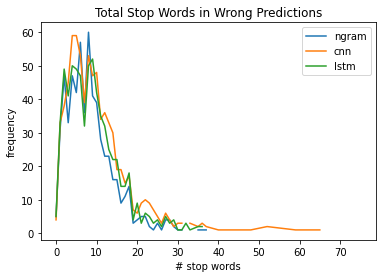

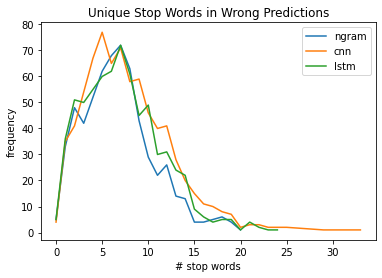

In [182]:
from pandas import Series
import matplotlib.pyplot as plt

ngram_u = Series(ngram_wrong_stop_unique).value_counts().sort_index()
ngram_t = Series(ngram_wrong_stop_total).value_counts().sort_index()

cnn_u = Series(cnn_wrong_stop_unique).value_counts().sort_index()
cnn_t = Series(cnn_wrong_stop_total).value_counts().sort_index()

lstm_u = Series(lstm_wrong_stop_unique).value_counts().sort_index()
lstm_t = Series(lstm_wrong_stop_total).value_counts().sort_index()

stops_unique = pd.DataFrame({'ngram': ngram_u, 'cnn': cnn_u, 'lstm': lstm_u})
stops_total = pd.DataFrame({'ngram': ngram_t, 'cnn': cnn_t, 'lstm': lstm_t})

stops_total.plot(title = 'Total Stop Words in Wrong Predictions', xlabel='# stop words', ylabel='frequency')
stops_unique.plot(title = 'Unique Stop Words in Wrong Predictions', xlabel='# stop words', ylabel='frequency')

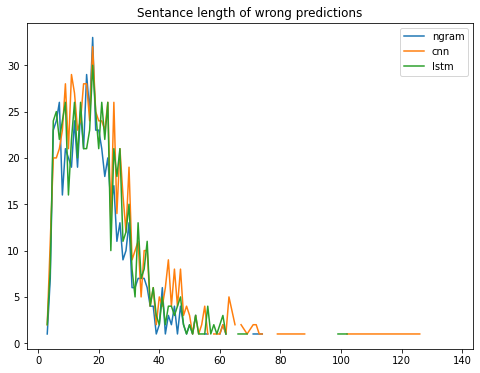

In [183]:
ngram_wrong_lengths = Series([len(x.split()) for x in ngram_wrong_text]).value_counts().sort_index()
cnn_wrong_lengths = Series([len(x.split()) for x in cnn_wrong_text]).value_counts().sort_index()
lstm_wrong_lengths = Series([len(x.split()) for x in lstm_wrong_text]).value_counts().sort_index()

lengths_df = pd.DataFrame({'ngram': ngram_wrong_lengths, 'cnn': cnn_wrong_lengths, 'lstm': lstm_wrong_lengths})
lengths_df.plot(figsize=(8,6),title='Sentance length of wrong predictions')

In [200]:
lengths_df['ngram'].describe()

count    61.000000
mean     10.131148
std       9.461281
min       1.000000
25%       1.000000
50%       6.000000
75%      19.000000
max      33.000000
Name: ngram, dtype: float64

In [208]:
#only_ngram_right = X_test.iloc[cnn_lstm_wrong.difference(set(ind_ngram))]